In [14]:
import numpy as np
import matplotlib.pyplot as plt
import baccoemu

In [15]:
def combine(biasvec, pnn):
    import itertools
    biasvec = np.concatenate([[1], biasvec])
    prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
    pgg = 0
    for i in range(15):
        fac = 2 if prod[i, 0] != prod[i, 1] else 1
        pgg += fac * biasvec[prod[i, 0]] * biasvec[prod[i, 1]] * pnn[i]
    return pgg

In [16]:
def mn_kmax(kmax, dmo=True):
    import os
    os.environ['OMP_NUM_THREADS'] = '1'
    from pymultinest.solve import solve
    from pymultinest import Analyzer

    import pickle
    with open('pij.pickle', 'rb') as f:
        pij = pickle.load(f)

    k = pij['dmopij'][0]['k']
    if dmo:
        pnn = [pij['dmopij'][i]['pk'] for i in range(len(pij['dmopij']))]
    else:
        pnn = [pij['bcmpij'][i]['pk'] for i in range(len(pij['bcmpij']))]

    fname = 'nenya_z0_pgg_pgm_pgm_bcm.pickle'
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    pggdata = data['pgg']
    k = pggdata['k']
    pgg = pggdata['pk']
    mask = k < kmax
    k = k[mask]
    pgg = pgg[mask]
    ndens = 1 / np.mean(pggdata['shotnoise'][pggdata['shotnoise'] > 0])
    print('ndens', ndens)

    Nk = pggdata['nmodes'][mask]
    pgg_err = np.sqrt(2 / Nk) * pgg
    pgg_err = np.sqrt(pgg_err**2 + (0.005 * pgg)**2)

    parameters = ['b1', 'b2', 'sb2', 'blap', 'Asn']
    latex = [r'b_{1}', r'b_2', r'b_{s^2}', r'b_{\nabla^2\delta}', r'A_{\rm sn}']
    bounds = [[-5, 5], [-5, 5], [-20, 20], [-1000, 1000], [0, 3]]

    def chi2_func(theta):
        b1, b2, bs2, blap, Asn = theta

        pgg_model = combine([b1, b2, bs2, blap], pnn)

        pgg_model += Asn / ndens

        pgg_model = pgg_model[mask]

        # print(b1, b2, bs2, blap, Asn)
        # print(pgg.shape)
        # print(pgg_model.shape)
        # print(pgg_err.shape)

        return np.sum(((pgg - pgg_model) / pgg_err)**2)

    def myprior(cube):
        for i in range(len(parameters)):
            cube[i] = cube[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0] # uniform linear priors
        return cube

    def myloglike(cube):
        chi2 = chi2_func(cube)
        return -0.5 * chi2

    os.system('mkdir -p .mpk_chains_fixed_ns')
    outputfiles_basename = '.mpk_chains_fixed_ns/test'

    result = solve(LogLikelihood=myloglike,
                   Prior=myprior,
                   n_dims=len(parameters),
                   n_params=len(parameters),
                   outputfiles_basename=outputfiles_basename,
                   evidence_tolerance=0.1,
                   n_live_points=400,
                   resume=False,
                   use_MPI=False,
                   verbose=True)
    a = Analyzer(len(parameters), outputfiles_basename=outputfiles_basename)
    stats = a.get_stats()
    bestfit_params = a.get_best_fit()
    samples = a.get_data()
    return {'kmax' : kmax, 'result' : result, 'samples' : samples, 'stats' : stats, 'bestfit' : bestfit_params,
            'bounds' : bounds, 'parameters' : parameters, 'latex' : latex, 'pk' : pgg, 'pk_err' : pgg_err}

In [17]:
import os
import pickle
kmaxes = [0.1, 0.2, 0.35, 0.5, 0.75]
mn = []
for kmax in kmaxes:
    fname = f'mn_fits_kmax{kmax}_z0_correctEmuErr_0p5perc_pgg_dmo.pickle'
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            _mn = pickle.load(f)
        mn.append(_mn['mn'])
    else:
        _mn = mn_kmax(kmax, dmo=True)
        mn.append(_mn)
        with open(fname, 'wb') as f:
            pickle.dump({'mn' : _mn}, f)

In [18]:
import os
import pickle
kmaxes = [0.1, 0.2, 0.35, 0.5, 0.75]
mnbcm = []
for kmax in kmaxes:
    fname = f'mn_fits_kmax{kmax}_z0_correctEmuErr_0p5perc_pgg_bcm.pickle'
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            _mn = pickle.load(f)
        mnbcm.append(_mn['mn'])
    else:
        _mn = mn_kmax(kmax, dmo=False)
        mnbcm.append(_mn)
        with open(fname, 'wb') as f:
            pickle.dump({'mn' : _mn}, f)

In [19]:
from getdist import MCSamples, plots

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


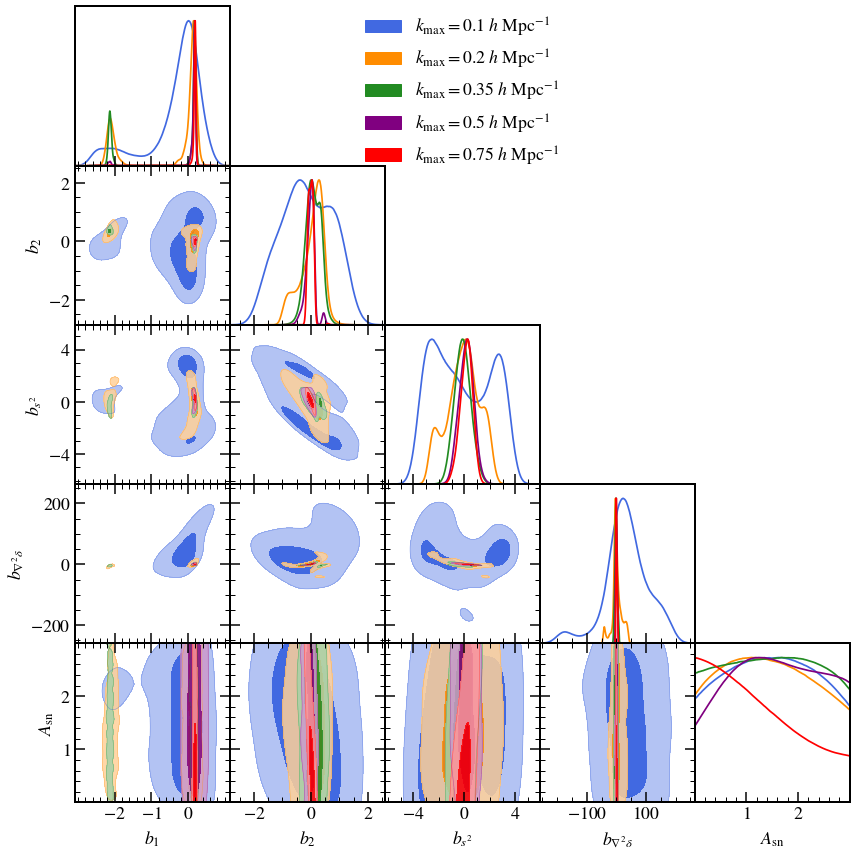

In [20]:
%matplotlib inline

gd_samples = []
for chain in mn:

    if chain['kmax'] > 0.9:
        continue

    bounds = {name : bound for name, bound in zip(chain['parameters'], chain['bounds'])}
    labels = chain['latex']
    samples = chain['samples'][:,2:]
    weights = chain['samples'][:,0]
    loglikes = chain['samples'][:,1]
    bestfits = chain['bestfit']['parameters']
    gd_samples.append(MCSamples(samples=samples, weights=weights, loglikes=loglikes,
                           label=r'$k_{\rm max} = %g \,\, h \,\, \mathrm{Mpc}^{-1}$'%(chain['kmax']),
                           names=chain['parameters'], labels=labels, ranges=bounds))
contour_args = {'contour_levels' : [np.exp(-0.5), np.exp(-2)]}

g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 20
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.fig_width_inch = 12
g.settings.linewidth = 2.5
g.settings.tight_layout = True
g.triangle_plot(gd_samples, filled=True, contour_colors=['royalblue','darkorange','forestgreen','purple','red'], contour_args=contour_args)

truths = None

# truths = [0.27, np.log(1e10*2.11065e-9), 0.049, 0.67]

if truths is not None:
    lw = 2
    for i in range(len(truths)):
        for j in range(i):
            g.subplots[i,j].axhline(truths[i], color='k', ls='--', lw=lw)
            g.subplots[i,j].axvline(truths[j], color='k', ls='--', lw=lw)
#             g.subplots[i,j].plot([bestfits[j]], [bestfits[i]], lw=0, ms=15, marker='*', mec='k', color='yellow')

    for i in range(len(truths)):
        g.subplots[i,i].axvline(truths[i], color='k', ls='--', lw=lw)

for i in range(g.subplots.shape[0]):
    g.subplots[i,i].tick_params(axis='y', which='minor', left=False)
# plt.suptitle(r'scaled volume cosmic variance + 2% theory error', fontsize=20, y=1.03)
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


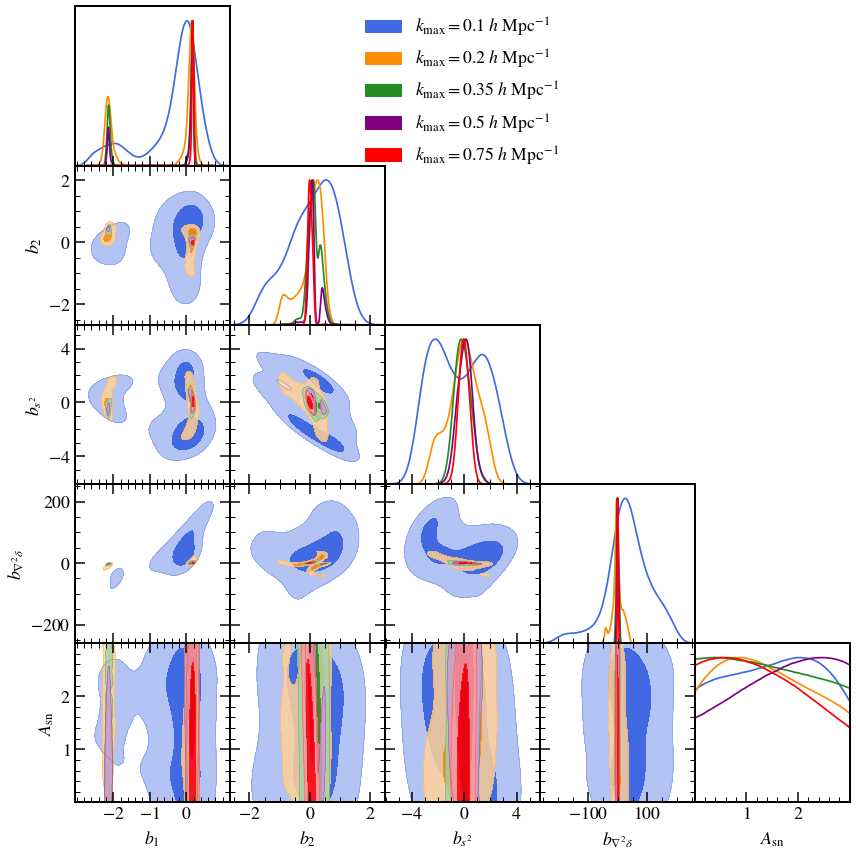

In [21]:
%matplotlib inline

gd_samples_bcm = []
for chain in mnbcm:

    if chain['kmax'] > 0.9:
        continue

    bounds = {name : bound for name, bound in zip(chain['parameters'], chain['bounds'])}
    labels = chain['latex']
    samples = chain['samples'][:,2:]
    weights = chain['samples'][:,0]
    loglikes = chain['samples'][:,1]
    bestfits = chain['bestfit']['parameters']
    gd_samples_bcm.append(MCSamples(samples=samples, weights=weights, loglikes=loglikes,
                                    label=r'$k_{\rm max} = %g \,\, h \,\, \mathrm{Mpc}^{-1}$'%(chain['kmax']),
                                    names=chain['parameters'], labels=labels, ranges=bounds))
contour_args = {'contour_levels' : [np.exp(-0.5), np.exp(-2)]}

g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 20
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.fig_width_inch = 12
g.settings.linewidth = 2.5
g.settings.tight_layout = True
g.triangle_plot(gd_samples_bcm, filled=True, contour_colors=['royalblue','darkorange','forestgreen','purple','red'], contour_args=contour_args)

truths = None

# truths = [0.27, np.log(1e10*2.11065e-9), 0.049, 0.67]

if truths is not None:
    lw = 2
    for i in range(len(truths)):
        for j in range(i):
            g.subplots[i,j].axhline(truths[i], color='k', ls='--', lw=lw)
            g.subplots[i,j].axvline(truths[j], color='k', ls='--', lw=lw)
#             g.subplots[i,j].plot([bestfits[j]], [bestfits[i]], lw=0, ms=15, marker='*', mec='k', color='yellow')

    for i in range(len(truths)):
        g.subplots[i,i].axvline(truths[i], color='k', ls='--', lw=lw)

for i in range(g.subplots.shape[0]):
    g.subplots[i,i].tick_params(axis='y', which='minor', left=False)
# plt.suptitle(r'scaled volume cosmic variance + 2% theory error', fontsize=20, y=1.03)
plt.show()

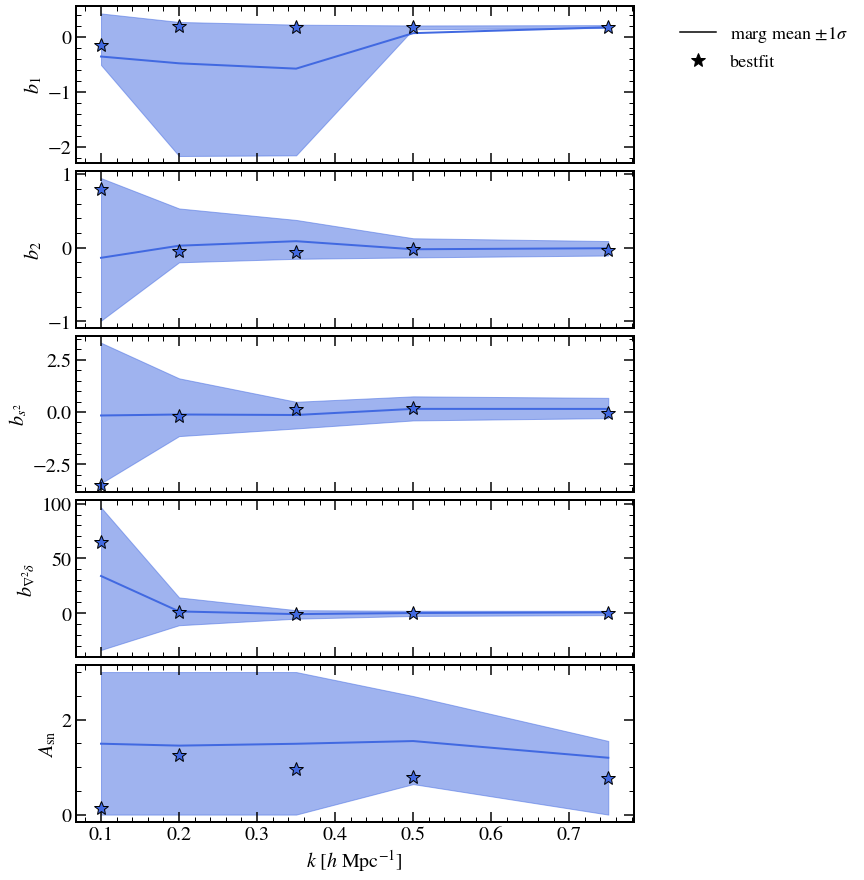

In [22]:
fig, ax = plt.subplots(len(mn[0]['parameters']), 1, figsize=(10, 15), sharex=True, gridspec_kw={'hspace':0.05, 'wspace':0.3})
ax = ax.flatten()

for ipar in range(len(mn[0]['parameters'])):

    upper = []
    lower = []
    mean = []
    bf = []
    for ik in range(len(kmaxes)):
        margstats = gd_samples[ik].getMargeStats()
        margstats_par = margstats.parWithName(mn[ik]['parameters'][ipar])
        upper.append(margstats_par.limits[0].upper)
        lower.append(margstats_par.limits[0].lower)
        mean.append(margstats_par.mean)
        bf.append(mn[ik]['bestfit']['parameters'][ipar])
    if truths is not None:
        ax[ipar].axhline(truths[ipar], color='k', ls='--')
    ax[ipar].fill_between(kmaxes, lower, upper, color='royalblue', alpha=0.5)
    ax[ipar].plot(kmaxes, mean, color='royalblue', lw=2)
    ax[ipar].plot(kmaxes, bf, lw=0, marker='*', color='royalblue', mec='k', ms=15)
    ax[ipar].set_ylabel(r'${}$'.format(mn[i]['latex'][ipar]), fontsize=20)

hh = [
      plt.Line2D([],[],color='k', ls='-', label=r'marg mean $\pm 1\sigma$'),
      plt.Line2D([],[],lw=0, marker='*', color='k', mec='k', ms=15, label='bestfit')
     ]
if truths is not None:
    hh.append(plt.Line2D([],[],color='k', ls='--', label='True value'))
ax[0].legend(handles=hh, loc='upper left', bbox_to_anchor=(1.05,1))

ax[-1].set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', fontsize=20)
plt.show()

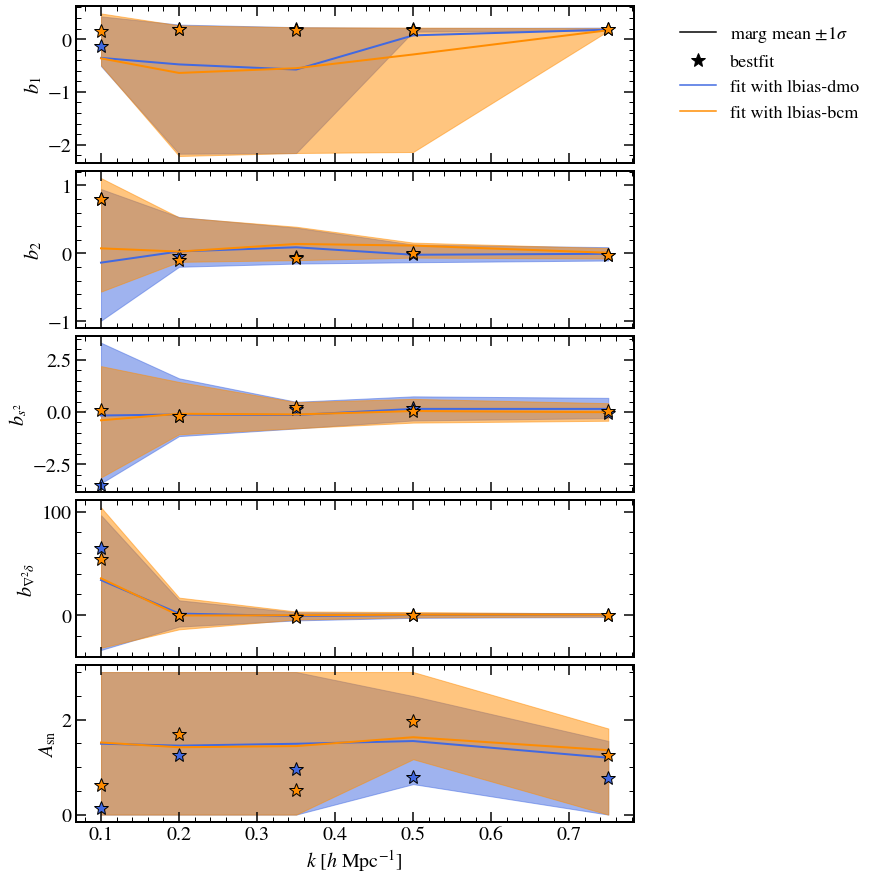

In [23]:
fig, ax = plt.subplots(len(mn[0]['parameters']), 1, figsize=(10, 15), sharex=True, gridspec_kw={'hspace':0.05, 'wspace':0.3})
ax = ax.flatten()

for ipar in range(len(mn[0]['parameters'])):

    upper = []
    lower = []
    mean = []
    bf = []
    for ik in range(len(kmaxes)):
        margstats = gd_samples[ik].getMargeStats()
        margstats_par = margstats.parWithName(mn[ik]['parameters'][ipar])
        upper.append(margstats_par.limits[0].upper)
        lower.append(margstats_par.limits[0].lower)
        mean.append(margstats_par.mean)
        bf.append(mn[ik]['bestfit']['parameters'][ipar])
    if truths is not None:
        ax[ipar].axhline(truths[ipar], color='k', ls='--')
    ax[ipar].fill_between(kmaxes, lower, upper, color='royalblue', alpha=0.5)
    ax[ipar].plot(kmaxes, mean, color='royalblue', lw=2)
    ax[ipar].plot(kmaxes, bf, lw=0, marker='*', color='royalblue', mec='k', ms=15)
    ax[ipar].set_ylabel(r'${}$'.format(mn[i]['latex'][ipar]), fontsize=20)

for ipar in range(len(mnbcm[0]['parameters'])):

    upper = []
    lower = []
    mean = []
    bf = []
    for ik in range(len(kmaxes)):
        margstats = gd_samples_bcm[ik].getMargeStats()
        margstats_par = margstats.parWithName(mnbcm[ik]['parameters'][ipar])
        upper.append(margstats_par.limits[0].upper)
        lower.append(margstats_par.limits[0].lower)
        mean.append(margstats_par.mean)
        bf.append(mnbcm[ik]['bestfit']['parameters'][ipar])
    if truths is not None:
        ax[ipar].axhline(truths[ipar], color='k', ls='--')
    ax[ipar].fill_between(kmaxes, lower, upper, color='darkorange', alpha=0.5)
    ax[ipar].plot(kmaxes, mean, color='darkorange', lw=2)
    ax[ipar].plot(kmaxes, bf, lw=0, marker='*', color='darkorange', mec='k', ms=15)
    ax[ipar].set_ylabel(r'${}$'.format(mnbcm[i]['latex'][ipar]), fontsize=20)

hh = [
      plt.Line2D([],[],color='k', ls='-', label=r'marg mean $\pm 1\sigma$'),
      plt.Line2D([],[],lw=0, marker='*', color='k', mec='k', ms=15, label='bestfit'),
      plt.Line2D([],[],color='royalblue', ls='-', label=r'fit with lbias-dmo'),
      plt.Line2D([],[],color='darkorange', ls='-', label=r'fit with lbias-bcm'),
     ]
if truths is not None:
    hh.append(plt.Line2D([],[],color='k', ls='--', label='True value'))
ax[0].legend(handles=hh, loc='upper left', bbox_to_anchor=(1.05,1))

ax[-1].set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', fontsize=20)
plt.show()

In [27]:
def mn_kmax_one(theta, kmax, dmo=True):
    import pickle
    with open('pij.pickle', 'rb') as f:
        pij = pickle.load(f)

    k = pij['dmopij'][0]['k']
    if dmo:
        pnn = [pij['dmopij'][i]['pk'] for i in range(len(pij['dmopij']))]
    else:
        pnn = [pij['bcmpij'][i]['pk'] for i in range(len(pij['bcmpij']))]

    fname = 'nenya_z0_pgg_pgm_pgm_bcm.pickle'
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    pggdata = data['pgg']
    k = pggdata['k']
    pgg = pggdata['pk']
    mask = k < kmax
    k = k[mask]
    pgg = pgg[mask]
    ndens = 1 / np.mean(pggdata['shotnoise'][pggdata['shotnoise'] > 0])
    print('ndens', ndens)

    Nk = pggdata['nmodes'][mask]
    pgg_err = np.sqrt(2 / Nk) * pgg
    pgg_err = np.sqrt(pgg_err**2 + (0.005 * pgg)**2)

    parameters = ['b1', 'b2', 'sb2', 'blap', 'Asn']
    latex = [r'b_{1}', r'b_2', r'b_{s^2}', r'b_{\nabla^2\delta}', r'A_{\rm sn}']
    bounds = [[-5, 5], [-5, 5], [-20, 20], [-1000, 1000], [0, 3]]

    def chi2_func(theta):
        b1, b2, bs2, blap, Asn = theta

        pgg_model = combine([b1, b2, bs2, blap], pnn)

        pgg_model += Asn / ndens

        pgg_model = pgg_model[mask]

        # print(b1, b2, bs2, blap, Asn)
        # print(pgg.shape)
        # print(pgg_model.shape)
        # print(pgg_err.shape)

        return np.sum(((pgg - pgg_model) / pgg_err)**2)

    def myprior(cube):
        for i in range(len(parameters)):
            cube[i] = cube[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0] # uniform linear priors
        return cube

    def myloglike(cube):
        chi2 = chi2_func(cube)
        return -0.5 * chi2

    b1, b2, bs2, blap, Asn = theta
    pgg_model = combine([b1, b2, bs2, blap], pnn)
    pgg_model += Asn / ndens
    pgg_model = pgg_model[mask]

    return {'theta': theta, 'k': k, 'pgg': pgg, 'pgg_err': pgg_err, 'pgg_model': pgg_model, 'chi2': chi2_func(theta), 'myloglike': myloglike(theta)}

ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523
ndens 0.009999990463481523


/tmp/ipykernel_146080/1930497469.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(bfdata['k'], bfdata['pgg'], yerr=bfdata['pgg_err'], fmt='o', capsize=3, marker='o', ms=8, color='k', zorder=0)
/tmp/ipykernel_146080/1930497469.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[1].errorbar(bfdata['k'], bfdata['pgg'], yerr=bfdata['pgg_err'], fmt='o', capsize=3, marker='o', ms=8, color='k', zorder=0)


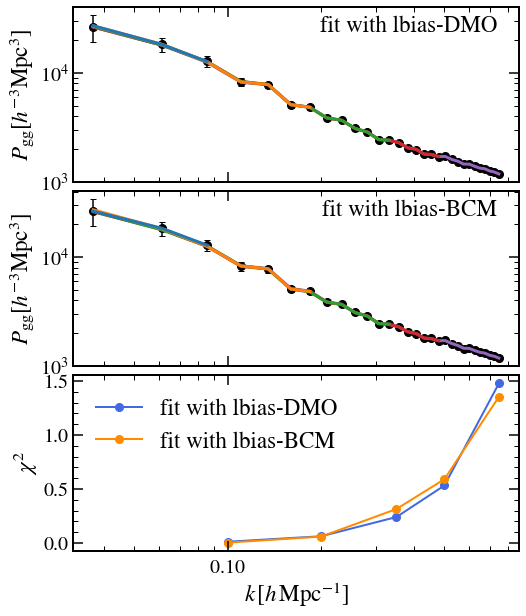

In [72]:
import bacco
from scipy import stats
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True, gridspec_kw={'hspace': 0.05})

bf = mn[-1]['bestfit']['parameters']
bfdata = mn_kmax_one(bf, kmaxes[-1])
ax[0].errorbar(bfdata['k'], bfdata['pgg'], yerr=bfdata['pgg_err'], fmt='o', capsize=3, marker='o', ms=8, color='k', zorder=0)
ax[1].errorbar(bfdata['k'], bfdata['pgg'], yerr=bfdata['pgg_err'], fmt='o', capsize=3, marker='o', ms=8, color='k', zorder=0)

chi2s_dmo = []
ks_dmo = []
models_dmo = []
for ik in range(len(kmaxes)):
    bf = mn[ik]['bestfit']['parameters']
    bfdata = mn_kmax_one(bf, kmaxes[ik])
    chi2s_dmo.append(bfdata['chi2'])
    ks_dmo.append(bfdata['k'])
    models_dmo.append(bfdata['pgg_model'])
chi2s_bcm = []
ks_bcm = []
models_bcm = []
for ik in range(len(kmaxes)):
    bf = mnbcm[ik]['bestfit']['parameters']
    bfdata = mn_kmax_one(bf, kmaxes[ik], dmo=False)
    chi2s_bcm.append(bfdata['chi2'])
    ks_bcm.append(bfdata['k'])
    models_bcm.append(bfdata['pgg_model'])
for ik in range(len(kmaxes))[::-1]:
    ax[0].loglog(ks_dmo[ik], models_dmo[ik], lw=3, color='C%i'%ik)
    ax[1].loglog(ks_bcm[ik], models_bcm[ik], lw=3, color='C%i'%ik)

chi2s_th = []
for ik in range(len(kmaxes)):
    chi2s_th.append(stats.chi2.ppf(0.95, np.max([len(ks_dmo[ik]) - 5, 1])))

ax[2].plot(kmaxes, chi2s_dmo, lw=2, marker='o', ms=8, color='royalblue', label='fit with lbias-DMO')
ax[2].plot(kmaxes, chi2s_bcm, lw=2, marker='o', ms=8, color='darkorange', label='fit with lbias-BCM')

ax[0].text(0.95, 0.95, r'fit with lbias-DMO', transform=ax[0].transAxes, fontsize=23, verticalalignment='top', horizontalalignment='right')
ax[1].text(0.95, 0.95, r'fit with lbias-BCM', transform=ax[1].transAxes, fontsize=23, verticalalignment='top', horizontalalignment='right')
ax[2].legend(fontsize=23)

ax[0].set_ylabel(r'$P_{\rm gg} [h^{-3} \mathrm{Mpc}^{3}]$', fontsize=23)
ax[1].set_ylabel(r'$P_{\rm gg} [h^{-3} \mathrm{Mpc}^{3}]$', fontsize=23)
ax[2].set_ylabel(r'$\chi^2$', fontsize=23)
ax[2].set_xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$', fontsize=23)

bacco.set_logticks(ax[2], axis='x')

plt.show()

15.50731305586545

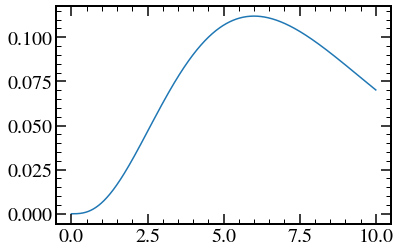

In [70]:
x = np.linspace(0, 10, 10000)
c2 = stats.chi2(8)
y = c2.pdf(x)
plt.plot(x, y)
c2.ppf(0.95)